In [45]:
# 0. Import package

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [46]:
# 1. Data collection

print("BTC-Data collected from trading view, BTC-index, monthly data.")
print("CPI-Data collected from trading view, USCPI-index, monthly data.")


BTC-Data collected from trading view, BTC-index, monthly data.
CPI-Data collected from trading view, USCPI-index, monthly data.


         time      open      high       low     close
0  2009-10-01  0.000764  0.001288  0.000764  0.001247
1  2009-11-01  0.001219  0.001355  0.000824  0.000824
2  2009-12-01  0.000811  0.000811  0.000613  0.000689
3  2010-01-01  0.000718  0.003366  0.000718  0.003298
4  2010-02-01  0.003297  0.005298  0.003297  0.005298


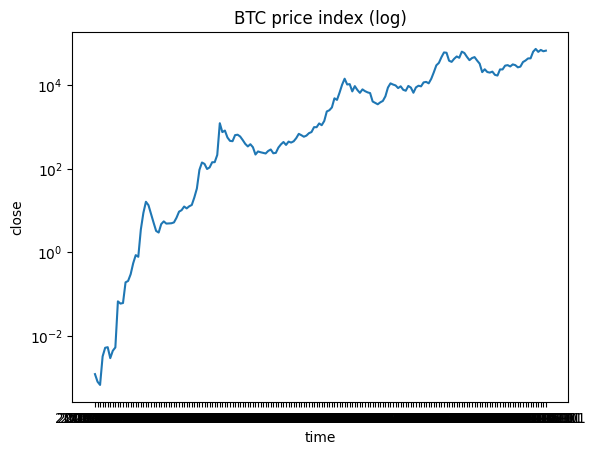

        time  close
0   1/7/1999  166.7
1   1/8/1999  167.1
2   1/9/1999  167.9
3  1/10/1999  168.2
4  1/11/1999  168.3


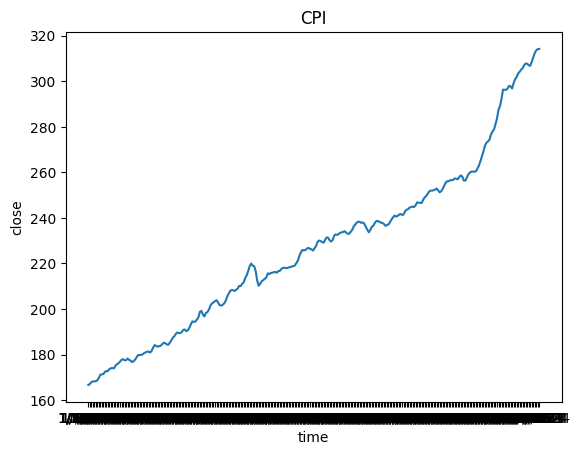

In [47]:
# 2. Data storage

# 2.1. Store BTC data
btc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/INDEX_BTCUSD, 1M.csv')
print(btc.head())
btc_line = sns.lineplot(data = btc, x = 'time', y = 'close')
btc_line.set_yscale('log')
btc_line.set_title("BTC price index (log)")
plt.show()

#2.2. Store CPI data
cpi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ECONOMICS_USCPI, 1M.csv')
print(cpi.head())
cpi_line = sns.lineplot(data = cpi, x = 'time', y = 'close')
cpi_line.set_title("CPI")
plt.show()


In [48]:
# 3. Data cleaning

# 3.1 BTC price index is meaningless before 2016
def date_clean(df, col):
  clean = df
  clean[col] = pd.to_datetime(df[col])
  clean['year'] = clean[col].dt.year
  clean['month'] = clean[col].dt.month
  clean = clean[clean['year'] >= 2016]
  clean = clean.dropna()
  clean = clean.drop(col, axis = 1)
  clean = clean.reset_index()

  return clean

# 3.2 Clean up data for BTC
btc_clean = date_clean(btc, 'time')

# 3.3 Clean up data for CPI
cpi_clean = date_clean(cpi, 'time')

# 3.4 Combine data
data = btc_clean[['year', 'month','close']]
data['cpi'] = cpi_clean['close']
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 0 to 101
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    102 non-null    int32  
 1   month   102 non-null    int32  
 2   close   102 non-null    float64
 3   cpi     102 non-null    float64
dtypes: float64(2), int32(2)
memory usage: 3.2 KB


<ipython-input-48-cc151f85f60f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cpi'] = cpi_clean['close']


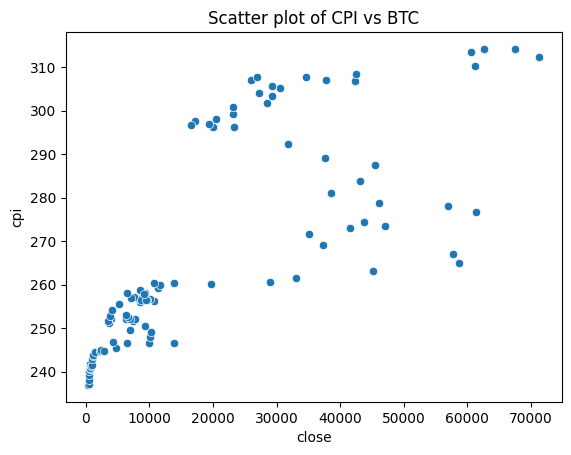

             close       cpi   dummy_1   dummy_2   dummy_3   dummy_4  \
close     1.000000  0.745648 -0.027585  0.036992  0.084474  0.061263   
cpi       0.745648  1.000000 -0.030833 -0.014290  0.002055  0.015068   
dummy_1  -0.027585 -0.030833  1.000000 -0.096774 -0.096774 -0.096774   
dummy_2   0.036992 -0.014290 -0.096774  1.000000 -0.096774 -0.096774   
dummy_3   0.084474  0.002055 -0.096774 -0.096774  1.000000 -0.096774   
dummy_4   0.061263  0.015068 -0.096774 -0.096774 -0.096774  1.000000   
dummy_5   0.028131  0.028640 -0.096774 -0.096774 -0.096774 -0.096774   
dummy_6   0.001676  0.043796 -0.096774 -0.096774 -0.096774 -0.096774   
dummy_7  -0.058294 -0.020165 -0.090753 -0.090753 -0.090753 -0.090753   
dummy_8  -0.058260 -0.014529 -0.090753 -0.090753 -0.090753 -0.090753   
dummy_9  -0.069621 -0.007083 -0.090753 -0.090753 -0.090753 -0.090753   
dummy_10 -0.007926  0.000017 -0.090753 -0.090753 -0.090753 -0.090753   
dummy_11 -0.006132 -0.001625 -0.090753 -0.090753 -0.090753 -0.09

In [49]:
# 4. Data analysis

# 4.1 Relationship between the variable
data_sca = sns.scatterplot(data = data, x = 'close', y = 'cpi')
data_sca.set_title('Scatter plot of CPI vs BTC')
plt.show()

# 4.2 Examine dummy factor
def dummy(df, col):
  dummy = pd.get_dummies(df[col])
  dummy = dummy.astype('int')
  dummy = dummy.drop(dummy.columns[-1], axis = 1)
  dummy = dummy.rename(columns = lambda x: 'dummy_' + str(x))
  clean = pd.concat([df, dummy], axis = 1)
  clean = clean.drop(col, axis = 1)

  return clean

data_clean = dummy(data, 'month')

# 4.3 Examine correlation and remove high correlation
data_clean = data_clean.drop('year', axis = 1)
print(data_clean.corr())


The score of the model is:  93.0 %
The mean square of the model is:  14165289.0
The root mean square of the model is:  3764.0


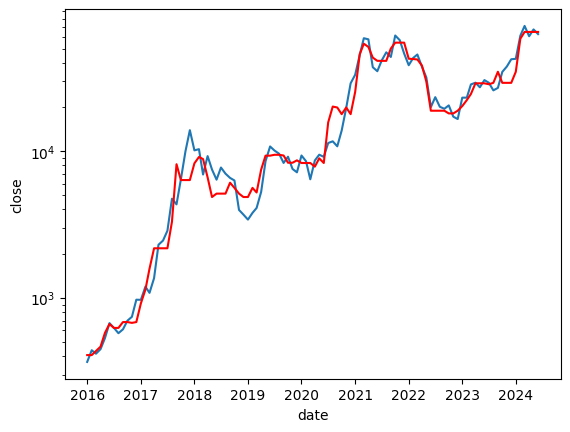

In [54]:
# 5. Machine learning

# 5.1 Seperate data
X = data_clean.drop(['close'], axis = 1)
y = data['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 21)

# 5.2 Build up model (KNN)
model = KNeighborsRegressor(n_neighbors = 3)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
predict = model.predict(X)
mse = mean_squared_error(predict, y)

print('The score of the model is: ', round(score * 100, 0), '%')
print('The mean square of the model is: ', round(mse, 0))
print('The root mean square of the model is: ', round(mse ** 0.5, 0))

data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str) + '-01')
result = sns.lineplot(x = data['date'], y = y)
result = sns.lineplot(x = data['date'], y = predict, color = 'red')
result.set_yscale('log')
plt.show()

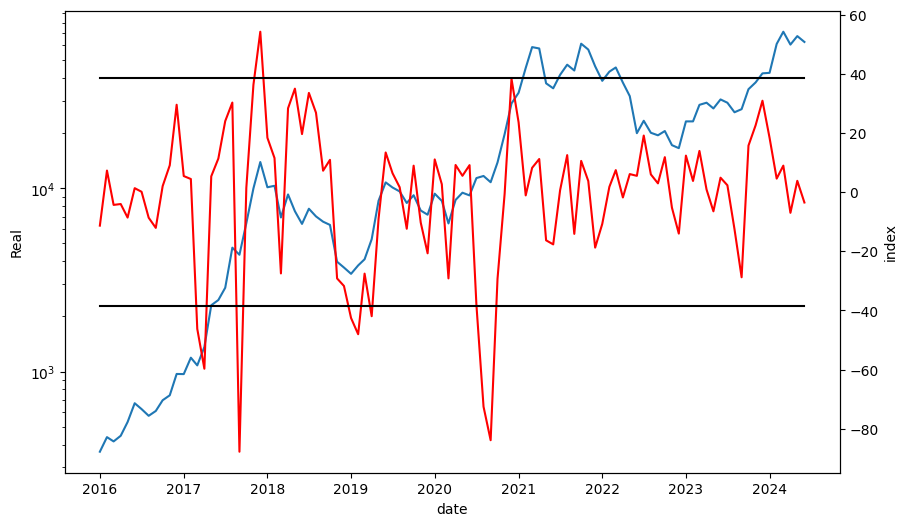

In [73]:
# 6. Machine learning production

# 6.1 Indicator dataframe
indicator = pd.DataFrame({
    'Predict': predict,
    'Real': y,
    'Error': y - predict
})

indicator['index'] = indicator['Error'] / indicator['Real'] * 100

# 6.2 Present the graph with bTC price
outlier = indicator['index'].mean() + indicator['index'].std() * 1.645

fig, ax1 = plt.subplots(figsize=(10, 6))

line1 = sns.lineplot(x = data['date'], y = indicator['Real'], ax=ax1)
line1.set_yscale('log')
ax1.tick_params(axis='y', colors='black')


ax2 = ax1.twinx()

sns.lineplot(x = data['date'], y = indicator['index'], color='red', ax=ax2)
sns.lineplot(x = data['date'], y = outlier, color='black', ax=ax2)
sns.lineplot(x = data['date'], y = -outlier, color='black', ax=ax2)
ax2.tick_params(axis='y', colors='black')

plt.show()
